In this notebook, we build time series forecasting models using:
- **ARIMA**: for modeling trend
- **SARIMA**: for modeling both trend and **seasonality**

We use the **AirPassengers** dataset, which shows strong seasonality and trend.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

**Dataset:**

Air passengers data 

In [3]:
data = pd.read_csv('/kaggle/input/airpassengers-dataframe/AirPassengers.csv')

In [4]:
data

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,112,118,132,129,121,135,148,148,136,119,104,118
1,115,126,141,135,125,149,170,170,158,133,114,140
2,145,150,178,163,172,178,199,199,184,162,146,166
3,171,180,193,181,183,218,230,242,209,191,172,194
4,196,196,236,235,229,243,264,272,237,211,180,201
5,204,188,235,227,234,264,302,293,259,229,203,229
6,242,233,267,269,270,315,364,347,312,274,237,278
7,284,277,317,313,318,374,413,405,355,306,271,306
8,315,301,356,348,355,422,465,467,404,347,305,336
9,340,318,362,348,363,435,491,505,404,359,310,337


Adding the year manually because that data is missing in the actually data

In [5]:
data['Year'] = list(range(1949, 1949 + len(data)))

In [6]:
data.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year
0,112,118,132,129,121,135,148,148,136,119,104,118,1949
1,115,126,141,135,125,149,170,170,158,133,114,140,1950
2,145,150,178,163,172,178,199,199,184,162,146,166,1951
3,171,180,193,181,183,218,230,242,209,191,172,194,1952
4,196,196,236,235,229,243,264,272,237,211,180,201,1953


changing the format of the data for proper analysis

In [7]:
df = data.melt(id_vars='Year', var_name='Month', value_name='Passengers')

In [8]:
df.head()

,Year,Month,Passengers
0,1949,Jan,112
1,1950,Jan,115
2,1951,Jan,145
3,1952,Jan,171
4,1953,Jan,196


conversion of year and month to proper data because timeseries works better on the datatime format data

In [9]:
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%b')
df.set_index('Date', inplace=True)
df = df[['Passengers']]

In [10]:
df.head()

,Passengers
Date,
1949-01-01,112
1950-01-01,115
1951-01-01,145
1952-01-01,171
1953-01-01,196


In [19]:
df = df.sort_index()

**Visualize Original Series**

We plot the AirPassengers dataset to inspect its trend.

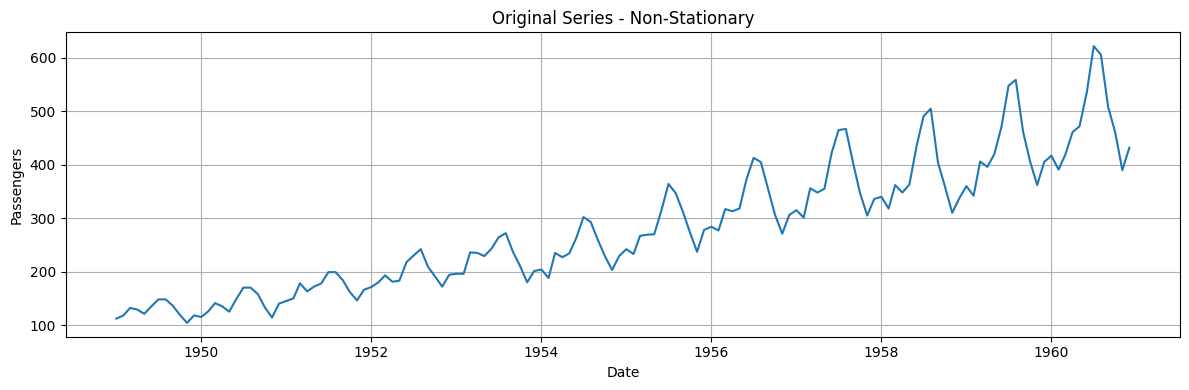

In [20]:
# Ensure Date index is sorted

plt.figure(figsize=(12, 4))
plt.plot(df['Passengers'])
plt.title("Original Series - Non-Stationary")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.grid(True)
plt.tight_layout()
plt.show()

**Fit ARIMA Model (p,d,q)**

*ARIMA Parameters:*

p=2: Use last 2 time values (AutoRegression)

d=1: Difference once to make series stationary

q=2: Use last 2 prediction errors (Moving Average)

This models short-term trend, but not seasonality.




In [28]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(df['Passengers'], order=(2, 1, 2))
result_arima = model_arima.fit()

print(result_arima.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Wed, 30 Jul 2025   AIC                           1353.347
Time:                        05:09:31   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.058      0.000       1.645       1.725
ar.L2         -0.9548      0.017    -55.418      0.000      -0.989      -0.921
ma.L1         -1.8432      0.125    -14.767      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Forecast Using ARIMA**

- Predicts the next 12 months

- Doesn’t include seasonal cycles

- Useful if your data is trend-only



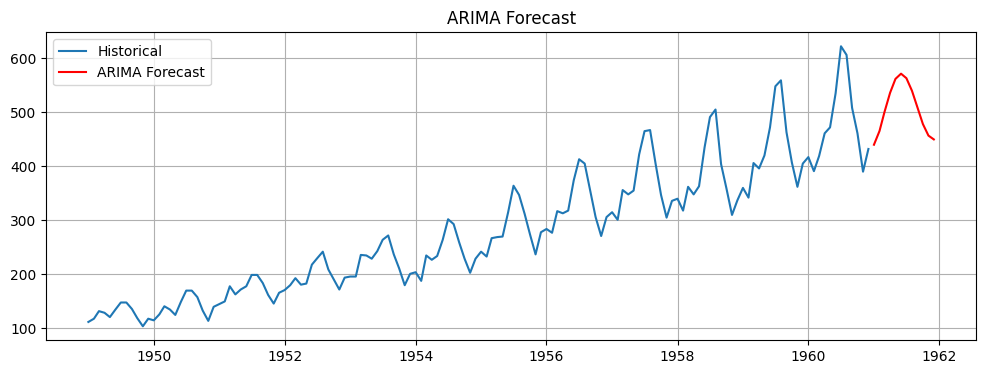

In [29]:
forecast_arima = result_arima.forecast(steps=12)

plt.figure(figsize=(12, 4))
plt.plot(df['Passengers'], label='Historical')
plt.plot(forecast_arima.index, forecast_arima.values, label='ARIMA Forecast', color='red')
plt.title("ARIMA Forecast")
plt.legend()
plt.grid(True)
plt.show()

**Fit SARIMA Model (p,d,q)(P,D,Q,s)**

*SARIMA Parameters:*
Non-seasonal (ARIMA part):

- p=1: lag of value

- d=1: differencing for trend

- q=1: lag of error

Seasonal:

- P=1: 12-month seasonal AR term

- D=1: seasonal differencing

- Q=1: seasonal MA term

- s=12: monthly data with yearly cycle

This handles both trend and annual seasonality.

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA — s=12 for monthly seasonality
model_sarima = SARIMAX(df['Passengers'],
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12))
result_sarima = model_sarima.fit()

print(result_sarima.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.149
Date:                            Wed, 30 Jul 2025   AIC                           1022.299
Time:                                    05:11:49   BIC                           1036.675
Sample:                                01-01-1949   HQIC                          1028.140
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1272      0.356     -0.357      0.721      -0.825       0.570
ma.L1         -0.2149      0.325   

**Forecast Using SARIMA**

- Produces forecast for next 12 months

- Includes confidence intervals

- More accurate for seasonal data



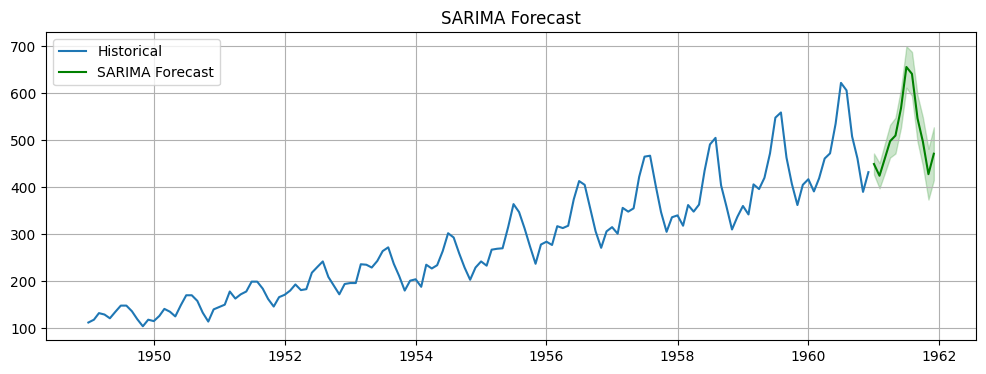

In [32]:
forecast_sarima = result_sarima.get_forecast(steps=12)
conf_int = forecast_sarima.conf_int()

plt.figure(figsize=(12, 4))
plt.plot(df['Passengers'], label='Historical')
plt.plot(forecast_sarima.predicted_mean, label='SARIMA Forecast', color='green')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='green', alpha=0.2)
plt.title("SARIMA Forecast")
plt.legend()
plt.grid(True)
plt.show()

SARIMA is usually better for real-world problems where patterns repeat at regular intervals (e.g., yearly, weekly).